In [463]:
import pandas as pd
import datetime
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
import seaborn as sns

import warnings                               
warnings.filterwarnings('ignore')

Thaughts:
 - Holidays dont make sense to add
 - Seasonality is hard in general 

In [464]:
df = pd.read_csv('../train.csv')
df[:10]

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
5,2018-01-01 12:10:00+00:00,103.805858,29.177815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,20.305917,NaN,NaN,274.00,3.781696
6,2018-01-01 12:20:00+00:00,89.304200,28.871782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.00,18.093654,NaN,NaN,265.00,3.727462
7,2018-01-01 12:30:00+00:00,136.319172,28.531796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,27.029096,NaN,NaN,255.00,4.154484
8,2018-01-01 12:40:00+00:00,217.112015,28.344782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.00,43.690222,NaN,NaN,249.00,4.642134
9,2018-01-01 12:50:00+00:00,256.428119,28.244747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.00,51.545672,NaN,NaN,241.00,4.841759


In [465]:
df.shape, df.isna().sum()

((77202, 20),
 Datetime                            0
 ActivePower                         0
 AmbientTemperatue                 896
 BearingShaftTemperature         26684
 Blade1PitchAngle                43282
 Blade2PitchAngle                43365
 Blade3PitchAngle                43365
 GearboxBearingTemperature       26682
 GearboxOilTemperature           26670
 GeneratorRPM                    26674
 GeneratorWinding1Temperature    26656
 GeneratorWinding2Temperature    26649
 HubTemperature                  26792
 MainBoxTemperature              26704
 NacellePosition                 20424
 ReactivePower                      42
 RotorRPM                        26680
 TurbineStatus                   26466
 WindDirection                   20424
 WindSpeed                         308
 dtype: int64)

Lots of nas lets mean impute.

In [466]:
df = df.fillna(df.drop(columns=['Datetime']).mean())
df.isna().sum()

Datetime                        0
ActivePower                     0
AmbientTemperatue               0
BearingShaftTemperature         0
Blade1PitchAngle                0
Blade2PitchAngle                0
Blade3PitchAngle                0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
NacellePosition                 0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64

Find variables with strong correlation to engineer some extranuous features for the model.

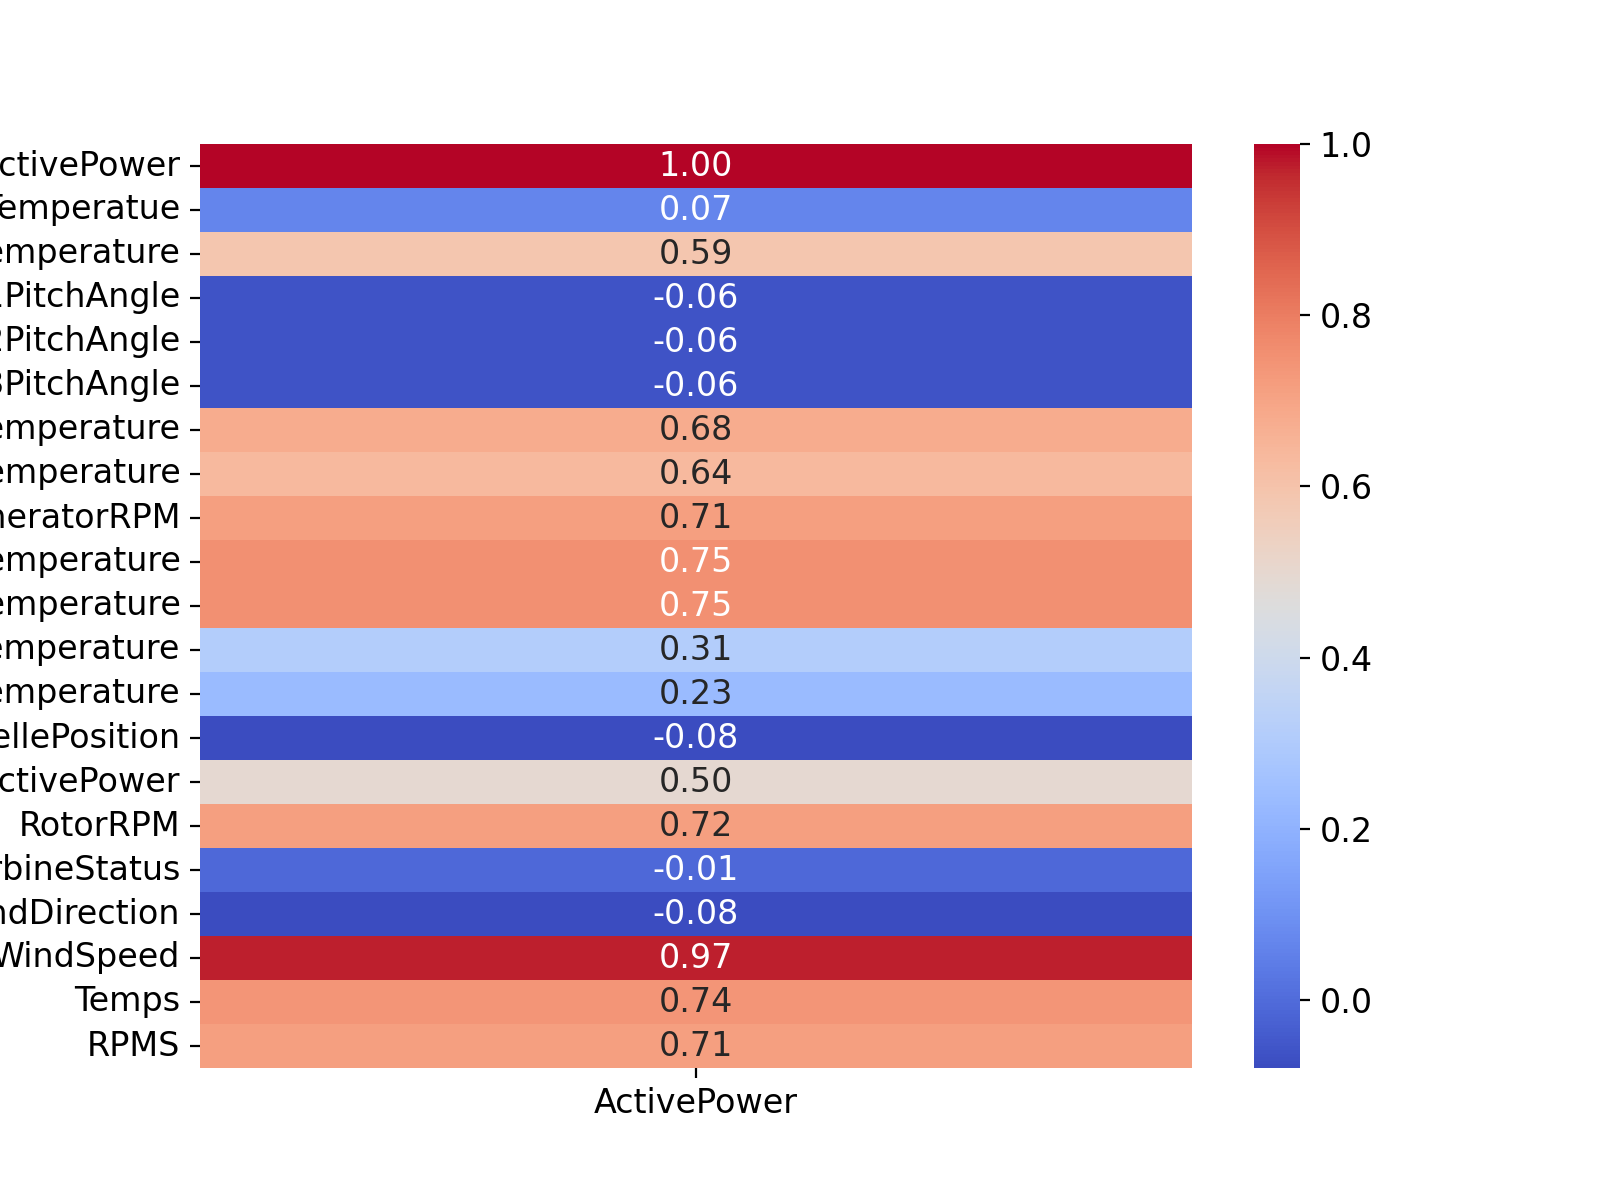

In [468]:
df['Temps'] = (df['GeneratorWinding2Temperature'] + df['GeneratorWinding2Temperature'] + df['GearboxBearingTemperature'] + df['GearboxOilTemperature'])
df['RPMS'] = (df['GeneratorRPM'] + df['RotorRPM'])

corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['ActivePower']], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


THis feature looks great, strong linear correlation.

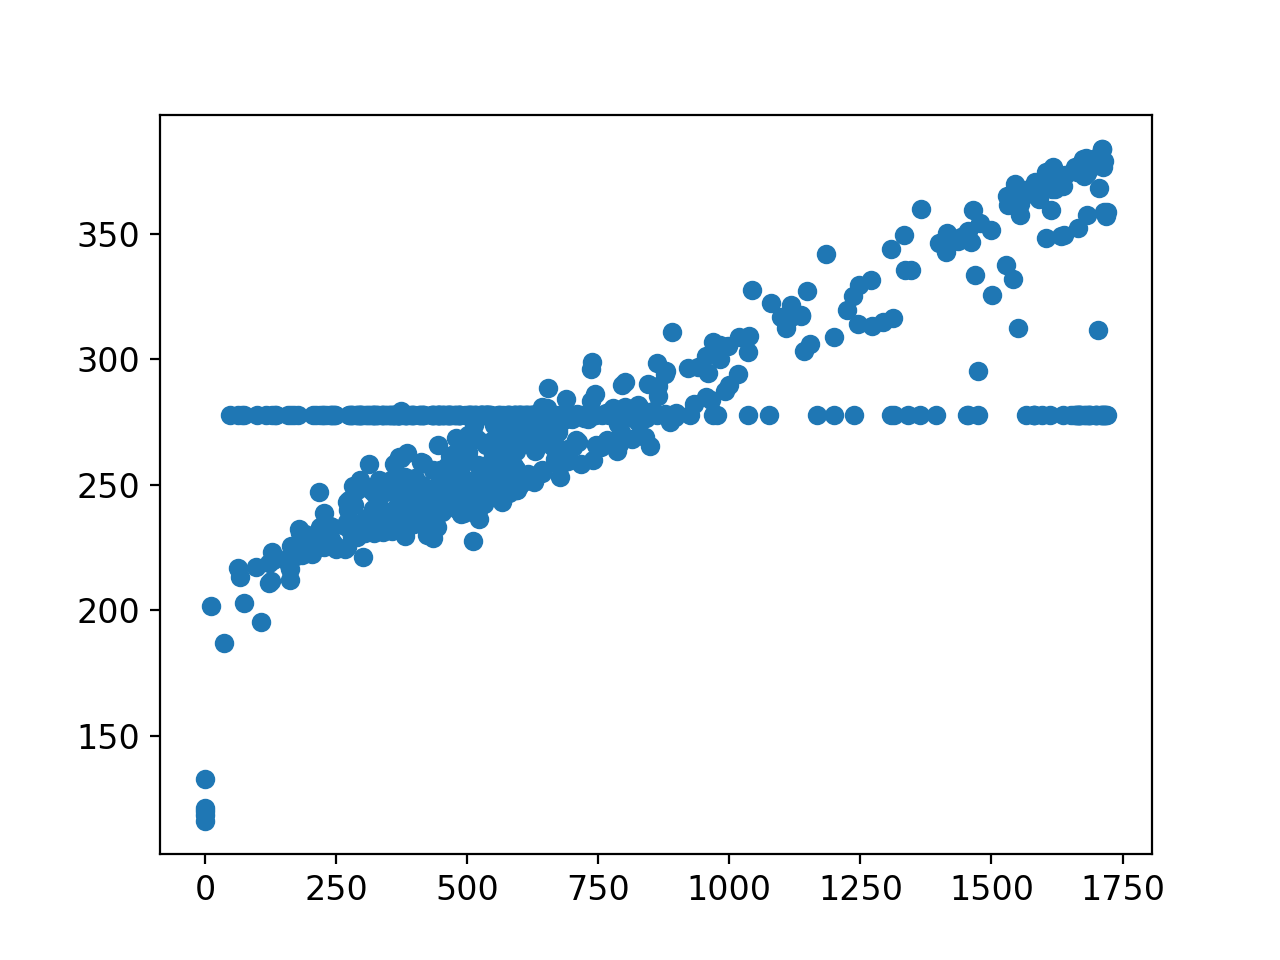

In [469]:
plt.scatter(df['ActivePower'], df['Temps']) #  horizontal line shows the mean impupted values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


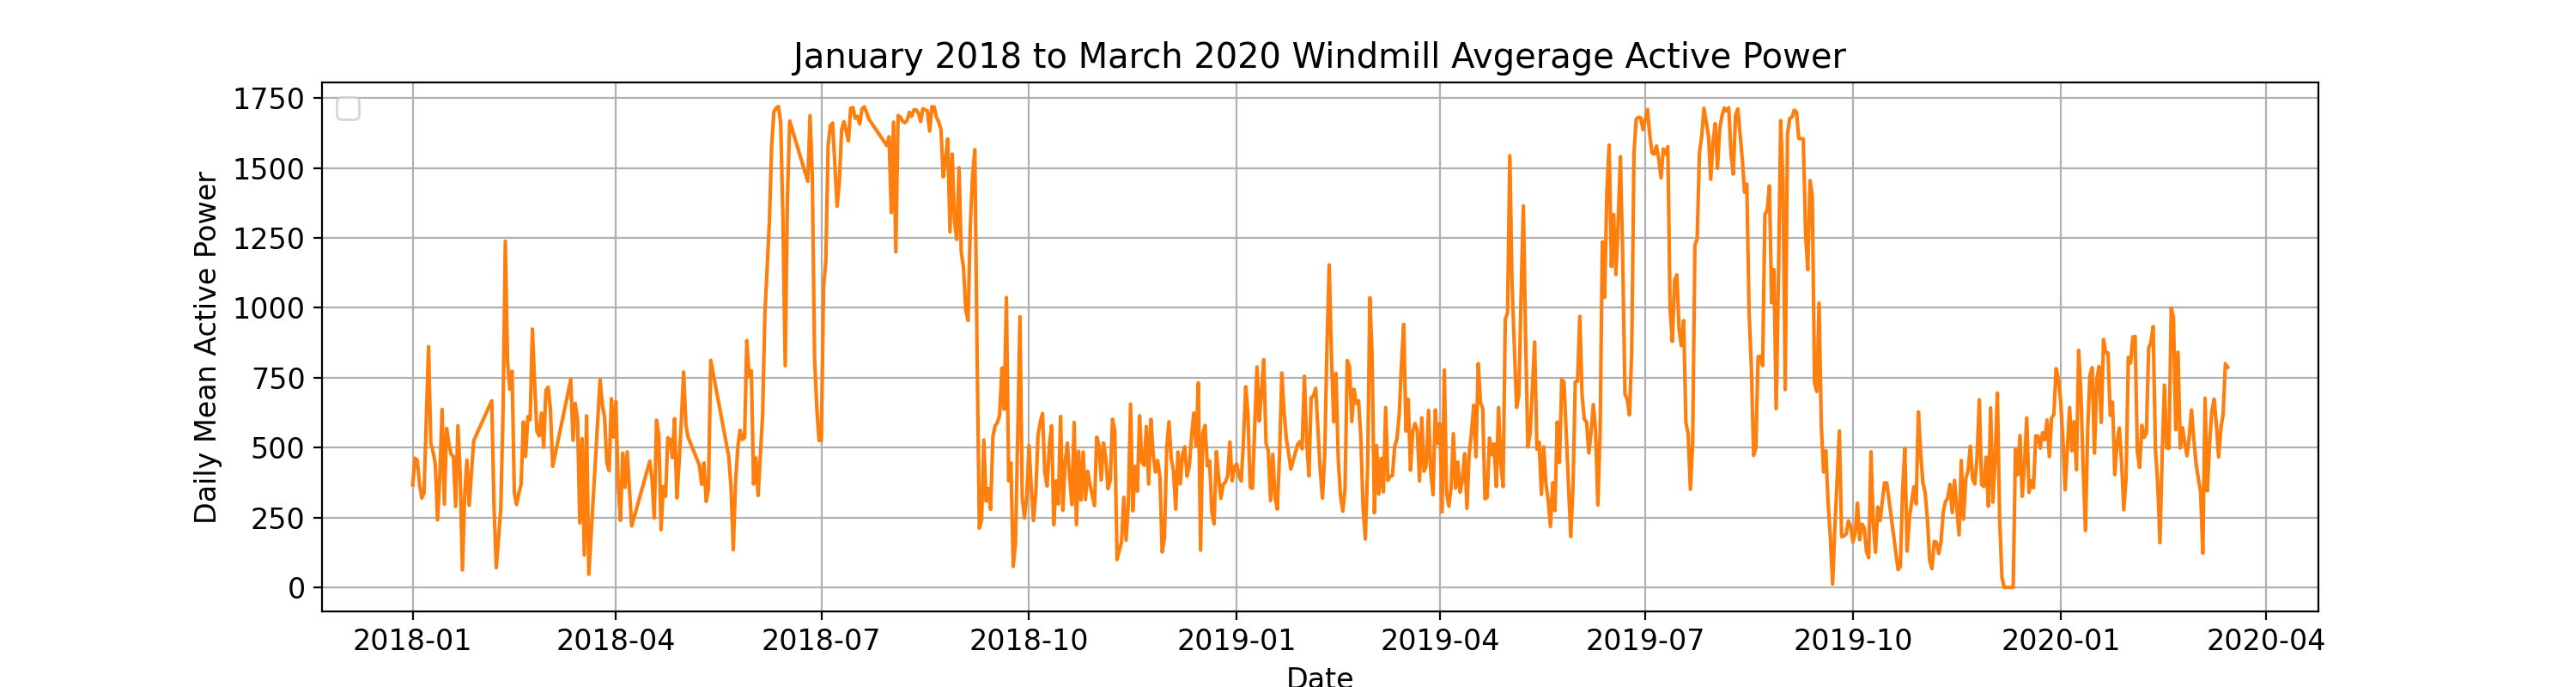

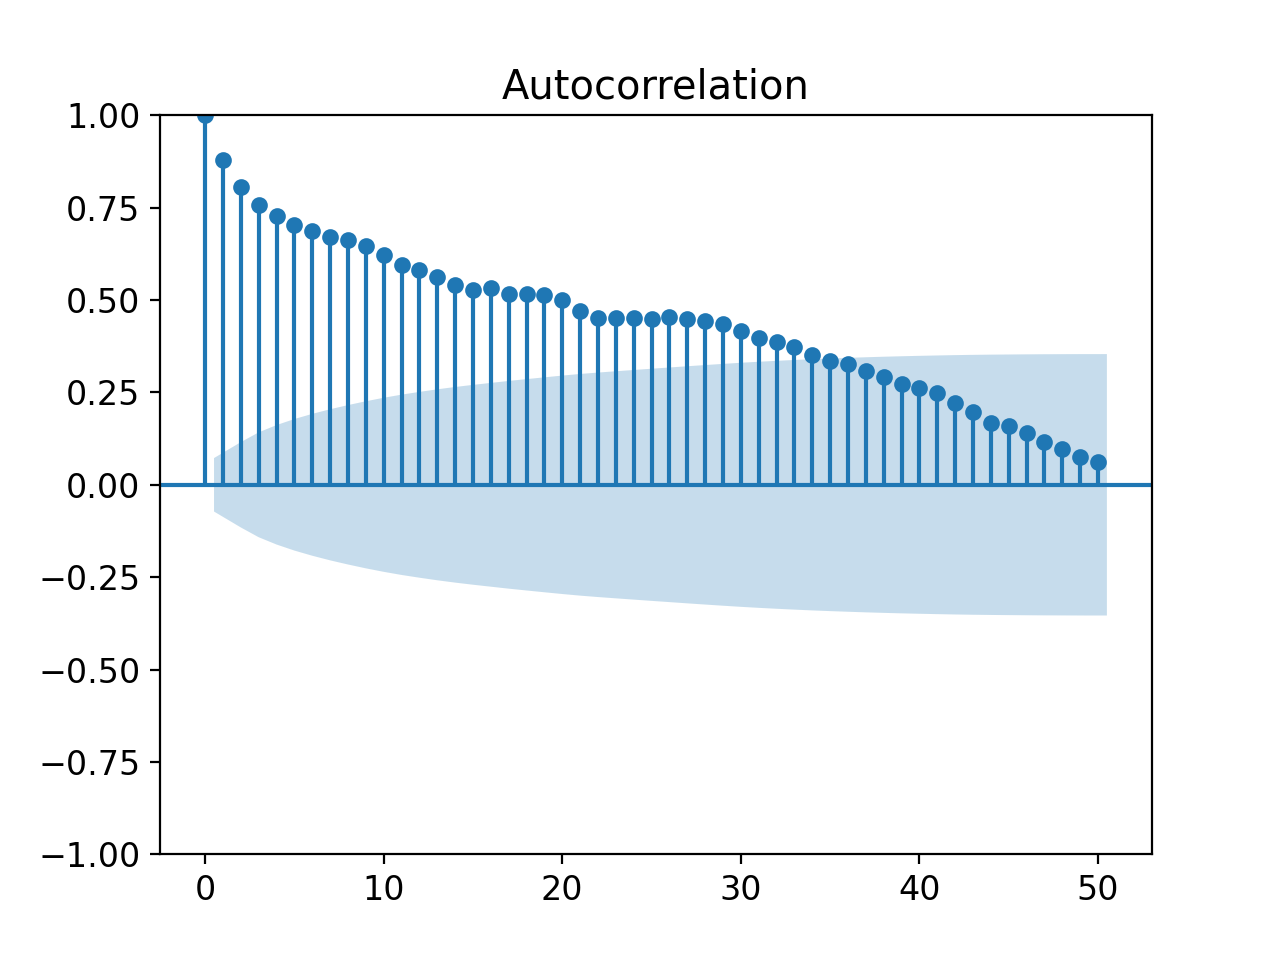

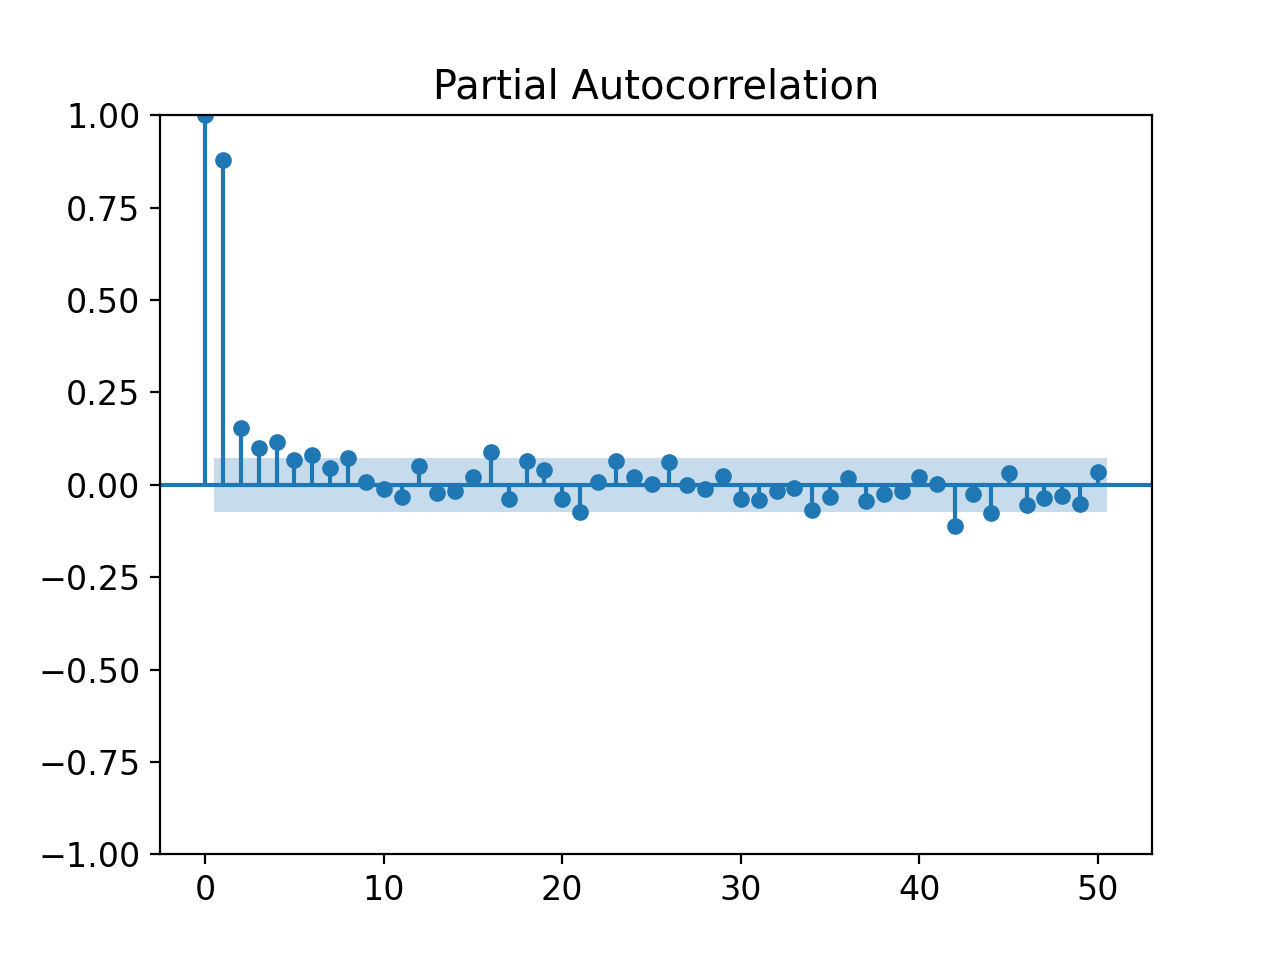


adf test p-value: 0.01792376595212781 ==> stationary


In [470]:
#time series plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df['ActivePower'], color='tab:orange')#, label='Daily Confirmed Case')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Mean Active Power')
ax.set_title('January 2018 to March 2020 Windmill Avgerage Active Power')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()
# ACF
plot_acf(df['ActivePower'],lags=50)
plt.show()
# PACF
plot_pacf(df['ActivePower'],lags=50)
plt.show()
# Dickey Fuller Test
adf_result = adfuller(df['ActivePower'], autolag="AIC")[1]
if adf_result <= 0.05:
    print(f'\nadf test p-value: {adf_result} ==> stationary')
else:
    print(f'\nadf test p-value: {adf_result} ==> non-stationary')

## SARIMAX model Attempt

In [471]:
def evaluate_models_cv_exog(dataset, exog, p_values, d_values, q_values, P_values, D_values, Q_values, m, k):
    K=k
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=31
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(K):
                                train, test = dataset[0:train_size+k*validation_size], dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                train_x, test_x = exog[0:train_size+k*validation_size], exog[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, exog=train_x, order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                predictions=model_fit.predict(start=train_size+k*validation_size, end=train_size+(k+1)*validation_size-1, exog=test_x)
                                # y_bar = test.mean(numeric_only=True)
                                rmse += np.sum(mean_squared_error(np.array(predictions), test)) / test.shape[0]
                            rmse_avg=rmse/K
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMAX%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_rmse))

SARIMAX Takes way to long to grid search... Lets try other models.

In [495]:
p = [0]
d = [0]
q = [0]
P = [5]
D = [0]
Q = [3]
m = 12
k = 2
# 

evaluate_models_cv_exog(df['ActivePower'], df[['GeneratorRPM', 'WindSpeed', 'Temps']], p, d, q, P, D, Q, m, k) # (0*3)(5,0,3,12) # 711.55

SARIMAX[(0, 0, 0), (5, 0, 3, 12)] RMSE=69.471
Best SARIMAX[(0, 0, 0), (5, 0, 3, 12)] RMSE=69.471


SARIMAX Results Forecasting 30 Days @ (0,0,0), (5,0,3):
 - ['Temps'], RMSE: 
 - ['GeneratorRPM', 'WindSpeed'], RMSE: 71.654
 - ['Temps', 'RotorRPM'], RMSE: 
 - ['Temps', 'WindSpeed', 'GeneratorRPM'], RMSE: 69.47
 - ['WindSpeed', 'RotorRPM'], RMSE: 

Looks good!

In [496]:
k = 31 #  Forecast length 
exog = ['Temps', 'WindSpeed', 'RotorRPM'] # Exogenous Variables to Include

y = df['ActivePower'][:-k]
X = df[exog][:-k]

testX, testY = df[exog][-k:], df['ActivePower'][-k:]

In [506]:
X.join(y)

,Temps,WindSpeed,RotorRPM,ActivePower
Datetime,,,,
2018-01-01,277.833454,5.263797,11.543193,366.223561
2018-01-02,277.833454,5.390719,11.543193,462.550740
2018-01-03,277.833454,5.295225,11.543193,454.417752
2018-01-04,277.833454,5.094994,11.543193,369.952190
2018-01-05,277.833454,4.915224,11.543193,319.446595
...,...,...,...,...
2020-02-09,279.416475,6.616840,11.888835,854.403582
2020-02-10,278.169189,6.820561,12.229086,877.905940
2020-02-11,282.027116,7.029250,12.562690,932.717865


In [510]:
len(y)

703

In [513]:
best_trend = (2,0,2)
best_seasonality = (0,2,2,12)
model = ARIMA(y, exog=X, order=best_trend, seasonal_order=best_seasonality).fit()
forecast = model.predict(start=len(y), end=len(y)+k-1, exog=testX)
print(f'SARIMA({best_trend}), ({best_seasonality}) RMSE: {np.sum(mean_squared_error(np.array(forecast), testY)) / testY.shape[0]}')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3099052934.py, line 11)

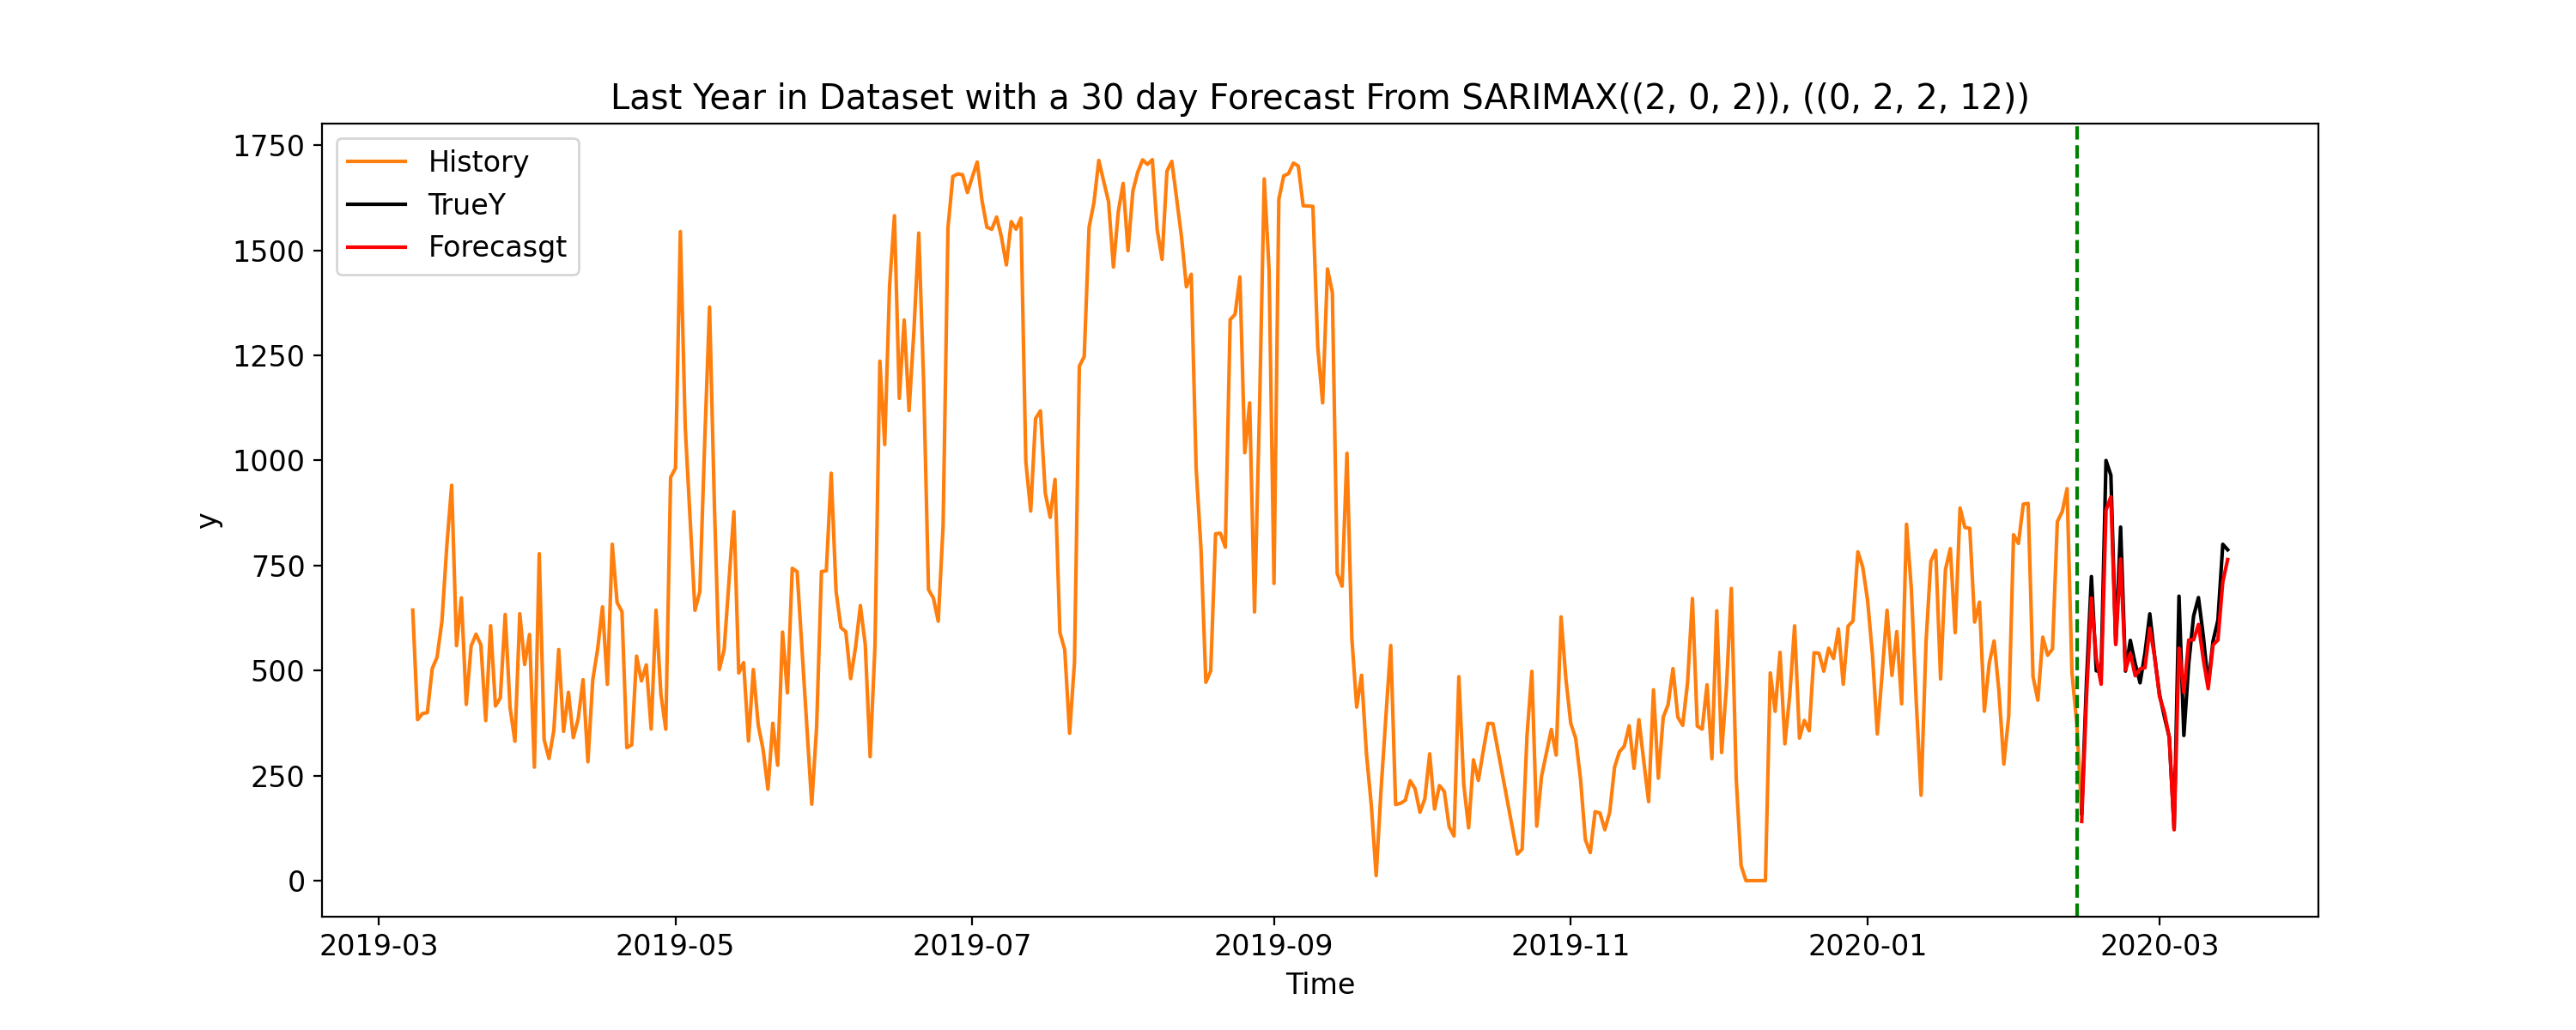

In [524]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))


ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecast, color='red', label='Forecasgt')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title(f'Last Year in Dataset with a 30 day Forecast From SARIMAX({best_trend}), ({best_seasonality})')
plt.legend()

## Theta Model Attempt

In [481]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.forecasting.theta import ThetaModel

theta_model = ThetaModel(y, period=k)
theta_fit = theta_model.fit()

forecasts = theta_fit.forecast(steps=k)
print(f'Theta RMSE: {np.sum(mean_squared_error(np.array(forecasts), testY)) / testY.shape[0]}')

Theta RMSE: 1859.7053847428065


Terrible.

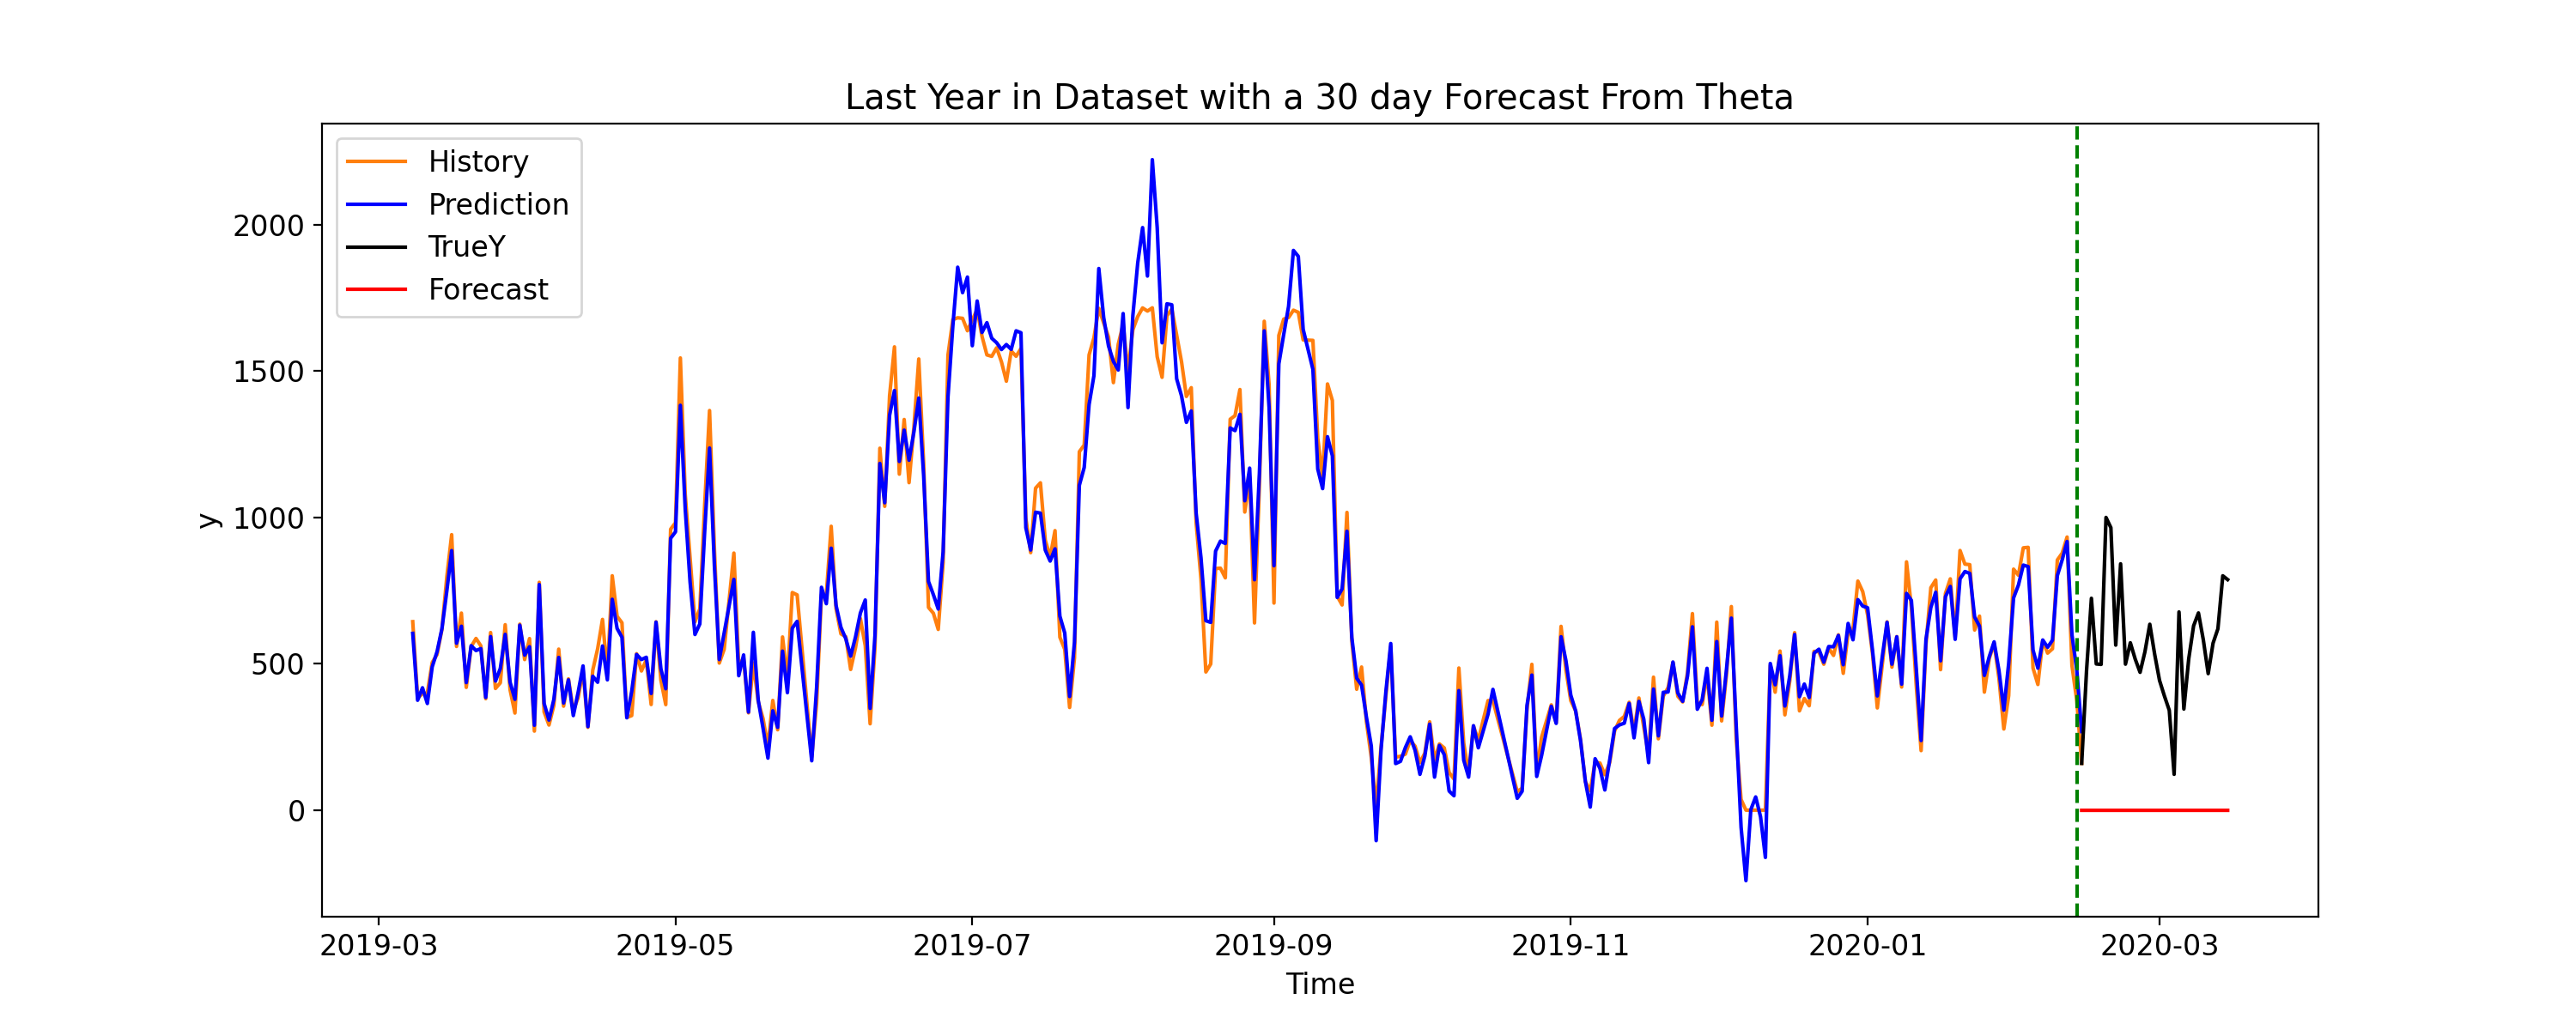

In [475]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecasts, color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From Theta')
plt.legend()

## Prophet Model Attempt

In [491]:
import prophet
# create df 
dataTrain = pd.DataFrame()
dataTrain['y'] = y
dataTrain['ds'] = df.index[:-k]
for og in exog:
    dataTrain[og] = X[og]
# make model
m = prophet.Prophet()
for og in exog:
    m.add_regressor(og)
m.fit(dataTrain)
# make df for predictions
future = m.make_future_dataframe(periods=k)
for og in exog:
    future[og] = df[og].values
# make predictions
forecast = m.predict(future)
print(f'Prophet RMSE:', (np.sum(mean_squared_error(forecast['yhat'][-k:], testY)) / testY.shape[0]))

18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 117.34095709587754


Prophet Results Forecasting 30 Days:
 - ['Temps'], RMSE: 1389.16
 - ['Temps', 'WindSpeed'], RMSE: 133.88
 - ['Temps', 'RotorRPM'], RMSE: 1379.29
 - ['Temps', 'WindSpeed', 'RotorRPM'], RMSE: 103.88
 - ['WindSpeed', 'RotorRPM'], RMSE: 110.19

Looks good!


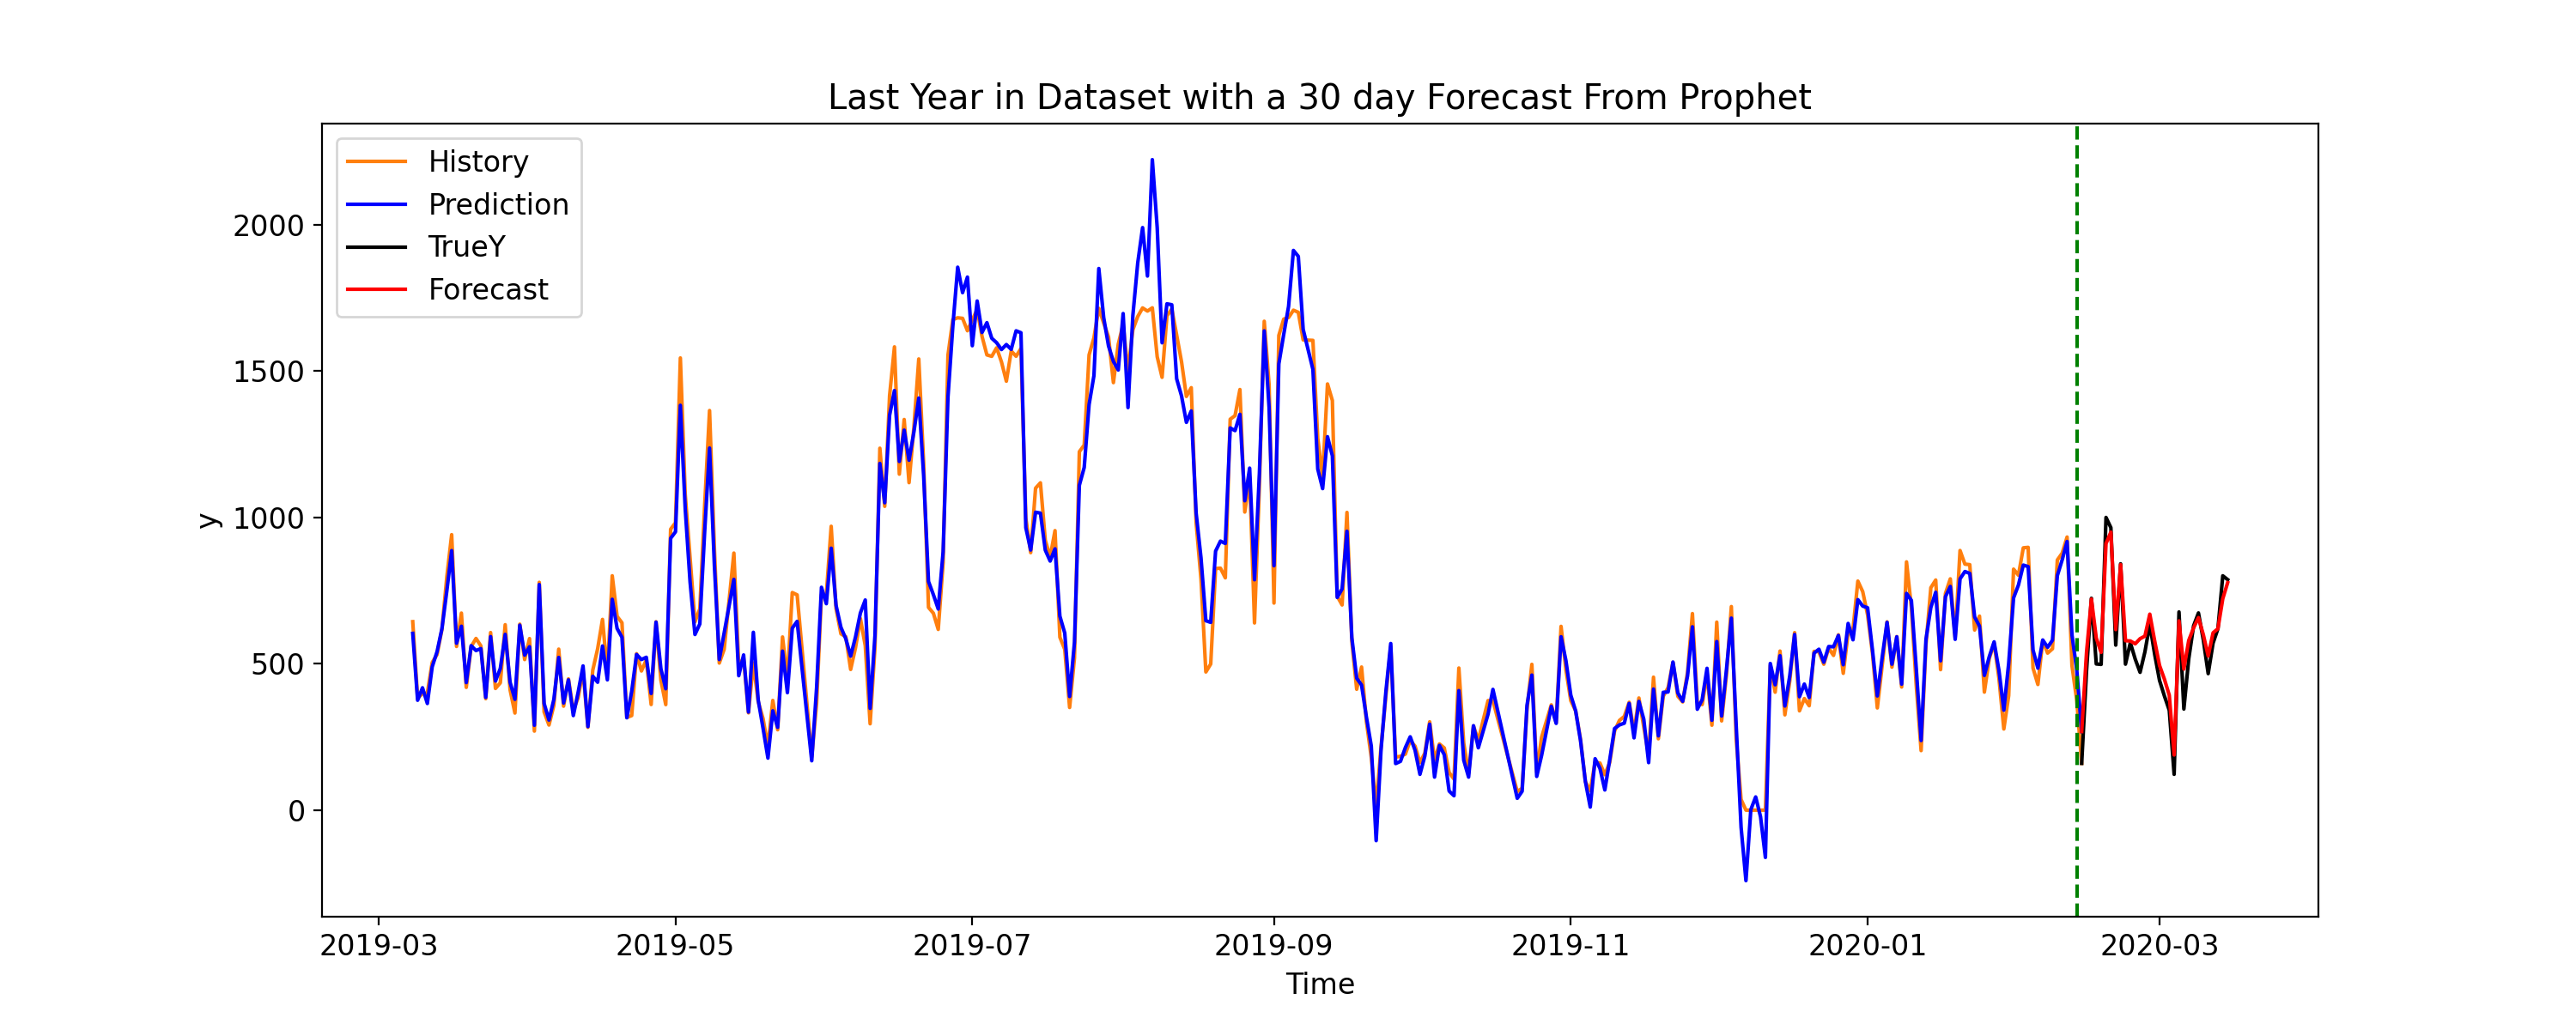

In [477]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')
ax.plot(df.index[-365:-k+1], forecast['yhat'][-365:-k+1], color='b', label='Prediction')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], forecast['yhat'][-k:], color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From Prophet')
plt.legend()